In [1]:
from random import sample
from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import faiss
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

### Prepare data

In [2]:
df = pd.read_csv("../data/spotify_playlists.csv")

In [3]:
df.head()

,playlist_id,track_id,track_uri,playlist_position,artist_name,track_name
0,9615,146723,spotify:track:6w2VaBGWcColW05nZROWvS,0,Tory Lanez,To D.R.E.A.M.
1,9615,158343,spotify:track:7hMqz88kcK2Tx6wBka9INF,1,Tory Lanez,All The Girls
2,9615,123985,spotify:track:5rqfg8Hz5D1aCcn2XUxzNA,2,Tory Lanez,Traphouse
3,9615,117440,spotify:track:5Z2S8VemQCfM02SLq8o5cR,3,Tory Lanez,One Day
4,9615,66611,spotify:track:39Y7nKwnEoMSfzbSVcAL0J,4,Tory Lanez,B.L.O.W.


In [4]:
n_track = df['track_id'].unique().shape[0]
n_playlist = df['playlist_id'].unique().shape[0]
print('tracks: {}, playlists: {}'.format(n_track, n_playlist))

tracks: 164576, playlists: 14750


In [5]:
N_TOP = 10

playlists_df = df.groupby('playlist_id')['track_id'].agg(neighbours=list)
playlists_df['n_neighbours'] = playlists_df['neighbours'].apply(len)
playlists_df = playlists_df[playlists_df['n_neighbours'] >= N_TOP].drop('n_neighbours', axis=1)

playlists = playlists_df['neighbours'].to_numpy()

In [6]:
playlists.size

14750

In [7]:
n_playlist_samples = N_TOP

triplets_id = []
for i in range(playlists.size):
    for _ in range(n_playlist_samples):
        anchor, positive = sample(playlists[i], 2)

        actual_idx = list(range(playlists.size))
        actual_idx.remove(i)
        negative = sample(sample(actual_idx, 1), 1)[0]

        if anchor != positive and anchor != negative and positive != negative:
            triplets_id.append((anchor, positive, negative))

In [8]:
triplets_id = list(set(triplets_id))
id2idx = {id: k for k, id in enumerate(set(chain.from_iterable(triplets_id)))}

triplets_idx = []
for t in triplets_id:
    triplets_idx.append((id2idx[t[0]], id2idx[t[1]], id2idx[t[2]]))

In [9]:
train_triplets, test_triplets = train_test_split(triplets_idx, test_size=0.2)

In [10]:
len(train_triplets), len(test_triplets)

(117924, 29482)

### Train

In [11]:
dim = 300
n_items = max(id2idx.values()) + 1

In [12]:
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(n_items, dim)
        self.linear = nn.Linear(dim, dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.linear(self.embedding(x)))

In [13]:
triplet_loss = nn.TripletMarginLoss()
embedder = Embedder()
opt = torch.optim.Adam(embedder.parameters(), lr=1e-3)

In [14]:
train_loader = DataLoader(train_triplets, batch_size=32, shuffle=True)
test_loader = DataLoader(test_triplets, batch_size=32, shuffle=True)

In [15]:
epochs = 3

In [16]:
%%time

train_losses, test_losses = [], []

for epoch in range(epochs):
    embedder.train()
    
    train_loss = 0
    for anchor_id, positive_id, negative_id in train_loader:
        anchor_vec = embedder(anchor_id)
        positive_vec = embedder(positive_id)
        negative_vec = embedder(negative_id)
        
        loss = triplet_loss(anchor_vec, positive_vec, negative_vec)
        loss.backward()

        opt.step()
        opt.zero_grad()

        train_loss += loss.item()
        
    embedder.eval()
    
    with torch.no_grad():
        test_loss = 0
        for test_anchor_id, test_positive_id, test_negative_id in test_loader:
            test_loss += triplet_loss(embedder(test_anchor_id), 
                                      embedder(test_positive_id),
                                      embedder(test_negative_id))

    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f"Epoch: {epoch + 1} Train Loss: {train_loss} Test Loss: {test_loss}")

Epoch: 1 Train Loss: 0.4670025406246656 Test Loss: 0.24359674751758575
Epoch: 2 Train Loss: 0.08555742668930888 Test Loss: 0.21242552995681763
Epoch: 3 Train Loss: 0.037135235144596546 Test Loss: 0.21206530928611755
CPU times: user 30min 48s, sys: 12min 28s, total: 43min 17s
Wall time: 6min 58s


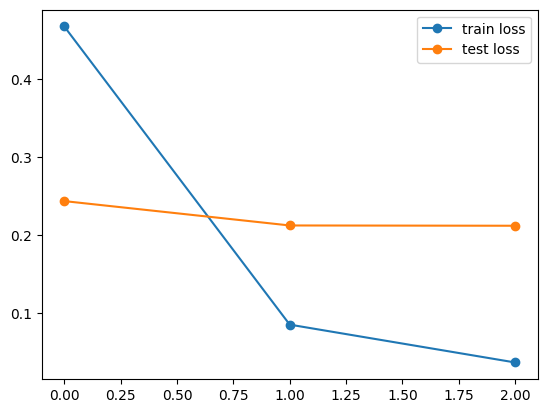

In [17]:
plt.plot(train_losses, 'o-', label='train loss')
plt.plot(test_losses, 'o-', label='test loss')
plt.legend();

### Metrics

In [18]:
def calc_embedding(id):
    return embedder(torch.tensor([id2idx[id]])).detach().numpy()[0]

In [19]:
df = df.merge(playlists_df,
                   left_on='playlist_id',
                   right_index=True)

df['embedding'] = df['track_id'].apply(lambda id: tuple(calc_embedding(id)) if id in id2idx else None)
df = df.dropna()

In [20]:
faiss_df = df[['track_id', 'embedding']].drop_duplicates()
faiss_df['idx'] = list(range(faiss_df.shape[0]))
tracks_vecs = np.array(faiss_df['embedding'].to_list())

In [21]:
index = faiss.IndexFlat(dim)   
index.add(tracks_vecs)          
print(index.ntotal)

90112


In [22]:
def search_closest(vec, index, topn=9):
    dist, idx = index.search(np.array([vec]), topn)
    return idx[0]

In [23]:
faiss_df['pred_neighbours_idx'] = faiss_df \
                                    .apply(lambda r: search_closest(r['embedding'], index), axis=1)

faiss_idx2id = dict(zip(faiss_df.idx, faiss_df.track_id))

faiss_df['pred_neighbours_id'] = faiss_df['pred_neighbours_idx'] \
                                    .apply(lambda neighbours: [faiss_idx2id[n] for n in neighbours])

In [24]:
df = df.merge(faiss_df[['track_id', 'pred_neighbours_id']], on='track_id')
df['neighbours'] = df.apply(lambda r: [n for n in r['neighbours'] if n != r['track_id']], axis=1)
df['pred_neighbours_id'] = df.apply(lambda r: [n for n in r['pred_neighbours_id'] if n != r['track_id']], axis=1)

In [25]:
def precision_at_k(true, pred):
    return len(set(pred) & set(true)) / len(pred)


def recall_at_k(true, pred):
    return len(set(pred) & set(true)) / len(true)


triplet_precision = df.apply(lambda r: precision_at_k(r['neighbours'], r['pred_neighbours_id']), axis=1).mean()
triplet_recall = df.apply(lambda r: recall_at_k(r['neighbours'], r['pred_neighbours_id']), axis=1).mean()

In [26]:
print("Triplet precision: {:.6f}".format(triplet_precision))
print("Triplet recall: {:.6f}".format(triplet_recall))

Triplet precision: 0.004261
Triplet recall: 0.000629


### Validation

In [27]:
id2name = {}
for i, t in df[['track_id', 'artist_name', 'track_name']].drop_duplicates().iterrows():
    id2name[t['track_id']] = [t['artist_name'], t['track_name']]

In [47]:
def search_track_id(track, artist):
    return df[df['artist_name'].str.contains(track) & 
              df['track_name'].str.contains(artist)].iloc[0]['track_id']


def similar_tracks(track, artist):
    target_id = search_track_id(track, artist)
    target_vec = df[df['track_id'] == target_id].iloc[0]['embedding']
    return [id2name[faiss_idx2id[idx]] for idx in search_closest(target_vec, index, 10+1)[1:]]

In [48]:
similar_tracks("The xx", "Intro")

[['Johnny Cash', 'These Hands - Live'],
 ['Tame Impala', 'Be Above It'],
 ['Meredith Andrews', 'Soar'],
 ['Incubus', 'Loneliest'],
 ['Hardwell', 'Apollo - Radio Edit'],
 ['MGMT', 'Weekend Wars'],
 ['Reba McEntire', 'Enough'],
 ['Emma Hewitt', 'Colours (Armin Van Buuren Remix)'],
 ['Henry John Gauntlett',
  "Once In Royal David's City - Desc. Stephen Cleobury"],
 ['Disclosure', 'Holding On']]

In [49]:
similar_tracks("Daft Punk", "One More Time")

[['Blues Image', 'Ride Captain Ride'],
 ['Joan Sebastian', 'Eso Y Mas'],
 ['Peixelétrico', 'Muviola'],
 ['Romeo Santos', 'Yo También'],
 ['David Crosby', 'Look In Their Eyes'],
 ['Mariah Carey', 'Obsessed'],
 ['The Jimmy Weeks Project', 'Homegrown'],
 ['Iron Maiden', 'Seventh Son Of A Seventh Son - 1998 Remastered Version'],
 ['Jason Derulo', 'Trumpets'],
 ['Boys Like Girls', 'Thunder']]

In [50]:
similar_tracks("Nirvana", "Come As You Are")

[['Black Star', 'Definition'],
 ['The Killers', 'Mr. Brightside'],
 ['Jai Wolf', 'Indian Summer'],
 ['DJ Khaled', "We Takin' Over"],
 ['George Ezra', 'Barcelona'],
 ['Mura Masa', 'When U Need Me'],
 ['Justin Timberlake',
  'CAN\'T STOP THE FEELING! (Original Song from DreamWorks Animation\'s "TROLLS")'],
 ['Brandi Carlile', 'The Things I Regret'],
 ['Grizzly Bear', 'Will Calls (Marfa Demo)'],
 ['Eagles', 'Hotel California - Remastered']]

In [51]:
similar_tracks("Beatles", "Yesterday")

[['The Weeknd', 'Starboy'],
 ['Mariah Carey', 'All I Want for Christmas Is You'],
 ['Vampire Weekend', "Don't Lie"],
 ['MC Chris', "Fett's Vette"],
 ['Skrillex', 'Bangarang (feat. Sirah)'],
 ['Hudson Thames', 'How I Want Ya'],
 ['Marc Anthony', 'Vivir Mi Vida'],
 ['Ugly God', 'L.D.C'],
 ['Sam Smith', 'Stay With Me'],
 ['Coolio', "Gangsta's Paradise"]]

In [52]:
similar_tracks("Olive", "You're Not Alone")

[['The C90s', 'Shine A Light - Flight Facilities Remix'],
 ['Bon Iver', '10 d E A T h b R E a s T ⚄ ⚄'],
 ['Tee Grizzley', 'No Effort'],
 ['Fantomas', '04/02/05 - Saturday'],
 ['The Piano Guys', 'Code Name Vivaldi'],
 ['Backstreet Boys', 'Larger Than Life'],
 ['Benny Goodman', 'Sing, Sing, Sing'],
 ['Pet Shop Boys', 'West End Girls - 2001 Remastered Version'],
 ['Rupee', 'Tempted To Touch - Album Edit'],
 ['Matchbox Twenty', "How Far We've Come"]]